so I will have data as ndarray at bottleneck as N by D
I will have the class labels acquired by kmeans
I want to find correspondance samples as
a) two random samples that are in cluster
b) some sample and the center sample

which wil be acquired as in and out indices by a function that takes nxd array and cluster labels

In [2]:
import importlib as impL
import sys
sys.path.insert(1,'/home/doga/GithUBuntU/keyhandshapediscovery/vae_torch')
sys.path.insert(1,'/home/doga/GithUBuntU/keyhandshapediscovery')
import vae_torch_model as vtm
import helperFuncs as funcH
import numpy as np
from pandas import DataFrame as pd_df

In [3]:
def load_from_saved_corr_file(fn = '/home/doga/Desktop/correspondance_find.npz'):
    a = np.load(fn)
    predictions = a['predictions']
    bottleneck_vec = a['bottleneck_vec']
    labels = a['labels']
    print("loaded from file - ", fn)
    print(predictions.shape)
    print(bottleneck_vec.shape)
    print(labels.shape)
    return bottleneck_vec, predictions, labels

def analyze_corresondance_results(correspondance_tuple, centroid_df, pred_vec, lab_vec):
    df = pd_df({'labels': lab_vec[np.asarray(centroid_df['sampleID'], dtype=int)],
                'klusterID': np.asarray(centroid_df['klusterID'], dtype=int),
                'sampleCounts': np.asarray(centroid_df['num_of_samples'], dtype=int)})
    print('correspondance results({:}):'.format(len(correspondance_tuple[0])))
    print(df.groupby(['labels'])[['labels', 'sampleCounts']].sum())
    corr_in_clust = pred_vec[correspondance_tuple[0]]
    corr_ou_clust = pred_vec[correspondance_tuple[1]]
    _confMat_corr_preds = confusion_matrix(corr_in_clust, corr_ou_clust)
    acc_corr_preds = 100 * np.sum(np.diag(_confMat_corr_preds)) / np.sum(
        np.sum(_confMat_corr_preds))
    print("_confMat_corr_preds - acc({:6.4f})".format(acc_corr_preds))

    corr_in_labels = lab_vec[correspondance_tuple[0]]
    corr_ou_labels = lab_vec[correspondance_tuple[1]]
    _confMat_corr = confusion_matrix(corr_in_labels, corr_ou_labels)
    acc_corr = 100 * np.sum(np.diag(_confMat_corr)) / np.sum(np.sum(_confMat_corr))
    print("confMat - acc({:6.4f}), correspondance match:\n".format(acc_corr), pd_df(_confMat_corr))

b_v = np.random.rand(10,3)
#print(b_v)

In [4]:
# np.savez('/home/doga/Desktop/correspondance_find.npz', bottleneck_vec=bottleneck_vec, predictions=pred_vec, labels=lab_vec)
bottleneck_vec, pred_vec, lab_vec = load_from_saved_corr_file('/home/doga/Desktop/correspondance_find_epoch1009_conf516.npz')

loaded from file -  /home/doga/Desktop/correspondance_find_epoch1009_conf516.npz
(60000,)
(60000, 32)
(60000,)


In [5]:
impL.reload(funcH)
def get_cluster_correspondance_ids_jupy(X, cluster_ids, correspondance_type="shuffle", verbose=0):
    # uses X to find the center sample
    # returns inds_in, inds_out where:
    # if correspondance_type=='shuffle'
    # inds_in : shuffled indices of a cluster
    # inds_out: shuffled indices of a cluster
    # elseif correspondance_type=='centered'
    # inds_in : some_sample_id
    # inds_out: the center of cluster of that sample_id
    centroid_df = funcH.get_cluster_centroids(ft=X, predClusters=cluster_ids, verbose=0)
    uq_pr = np.unique(cluster_ids)
    inds_in = []
    inds_out = []
    num_of_samples = []
    for i in range(len(uq_pr)):
        cluster_id = uq_pr[i]
        cluster_inds = funcH.getInds(cluster_ids, i)
        num_of_samples.append(len(cluster_inds))
        if correspondance_type == 'shuffle':
            iin_cur = cluster_inds.copy()
            np.random.shuffle(iin_cur)
            out_cur = cluster_inds.copy()
            np.random.shuffle(out_cur)
        elif 'knear' in correspondance_type:
            if verbose > 0:
                print("\n***\nknear-row{:}\n".format(i), cluster_inds)
            k = int(correspondance_type.replace('knear', ''))
            # look at the closest k samples for each sample
            X_sub = X[cluster_inds, :]
            k = np.minimum(len(cluster_inds), k)
            d_inds, d_vals = funcH.get_dist_inds(X_sub, k=k, metric="euclidean", verbose=0)
            # d_inds are from 0 to len(cluster_inds)
            # we want to switcth them with real cluster_inds
            if verbose > 2:
                print("cluster_inds:\n", cluster_inds)
                print("d_inds in:", d_inds)
            # d_inds.shape = [len(cluster_inds), k]
            # each row represents a sample and all columns represent its nearest neighbours
            # so i need to have each corr and k neighbours as correspondant frames
            sidx = np.array([cluster_inds, ] * k).T.flatten()
            if verbose > 1:
                print("i = ", i)
                print("sidx = \n", sidx)
            d_inds = cluster_inds[d_inds.flatten()]
            if verbose > 1:
                print("d_inds = \n", d_inds)
            iin_cur = sidx.copy()
            out_cur = d_inds.copy()
        else:
            center_sample_inds = centroid_df['sampleID'].iloc[i]
            if verbose > 0:
                print("cluster_id({:-3d}), sampleCount({:-4d}), centerSampleId({:-5d})".format(int(cluster_id),
                                                                                               len(cluster_inds),
                                                                                               center_sample_inds))
            # inds_in <--all sampleids except cluster center
            # inds_out<--cluster sample id with length of inds_in
            iin_cur = np.asarray(cluster_inds[np.where(center_sample_inds != cluster_inds)], dtype=int).squeeze()
            out_cur = np.asarray(np.ones(iin_cur.shape) * center_sample_inds, dtype=int)

        if verbose > 0:
            print("iin_cur.shape{:}, out_cur.shape{:}".format(iin_cur.shape, out_cur.shape))
            #if i == 0:
            print("iin=", iin_cur)
            print("out=", out_cur)
        inds_in.append(iin_cur)
        inds_out.append(out_cur)

    # first concatanate the lists into ndarray
    inds_in = np.asarray(np.concatenate(inds_in), dtype=int)
    inds_out = np.asarray(np.concatenate(inds_out), dtype=int)

    if True:  # 'knear' not in correspondance_type:
        # now a-b and b-a
        ii_ret = np.asarray(np.concatenate([inds_in, inds_out]), dtype=int)
        io_ret = np.asarray(np.concatenate([inds_out, inds_in]), dtype=int)
    else:
        ii_ret = inds_in.copy()
        io_ret = inds_out.copy()

    # now shuffle so that clusters not sorted in learning
    print("shuffle all")
    p = np.random.permutation(len(ii_ret))
    ii_ret = ii_ret[p]
    io_ret = io_ret[p]

    if verbose > 0:
        print("inds_in.shape{:}, inds_out.shape{:}".format(inds_in.shape, inds_out.shape))
    centroid_df['num_of_samples'] = num_of_samples
    return (ii_ret, io_ret), centroid_df

In [6]:
correspondance_type = 'knear1'
impL.reload(funcH)
correspondance_tuple, centroid_df = get_cluster_correspondance_ids_jupy(X=bottleneck_vec, cluster_ids=pred_vec,
                                    correspondance_type=correspondance_type,
                                    verbose=0)

shuffle all


In [7]:
from sklearn.metrics import confusion_matrix
analyze_corresondance_results(correspondance_tuple, centroid_df, pred_vec, lab_vec)

correspondance results(120000):
        labels  sampleCounts
labels                      
0            0          5267
1            4          4972
2            8          8264
3            9          4731
4           12          6064
5           10          5262
6           24          7302
7            7          3106
8           24          4664
9           45         10368
_confMat_corr_preds - acc(100.0000)
confMat - acc(73.1167), correspondance match:
       0      1     2     3     4     5     6     7      8      9
0  8520    107   215   863   122     8  2027     1    171      2
1   107  10930    97   602    36     0   120     0     10      0
2   215     97  6834   184  2349     3  2108     0    144      1
3   863    602   184  8734   858     2   633     0    126      2
4   122     36  2349   858  6666     0  1804     0     97      1
5     8      0     3     2     0  9942     8  1230     84    665
6  2027    120  2108   633  1804     8  5218     0    264      2
7     1      0   

In [ ]:
impL.reload(funcH)
corr_inds, centroid_df = funcH.get_cluster_correspondance_ids(b_v, cluster_ids=[0,0,0,0,1,1,2,2,1,1], correspondance_type="knear4", verbose=0)
print(pd_df({"in":corr_inds[0],"out":corr_inds[1]}))
print(centroid_df)

In [ ]:
a,  centroid_df = get_cluster_correspondance_ids(bottleneck_vec, predictions, correspondance_type="shuffle")

In [ ]:
import vae_scripts as vs

In [ ]:
vs.run_compare_list(experiments_folder="/home/doga/DataFolder/vaesae_experiments_cor",
                     data_log_keys=['tr_te', 'te'],
                     loss_key_list=[ 'bottleneck_kmeans', 'reconstruction'],
                     exp_base_name='exp_linear_vae_FMNIST_is28_cf',
                     ae_f_name_base='ae_ft_linear_vae_FMNIST_is28.npy')

tr_te  - log is loaded with len:  1009
te  - log is loaded with len:  1009
skipping -  valid loss
skipping -  reconstruction
bottleneck_kmeans :
tr_te: min(@epoc370:18.6367), max(@epoc515:64.5383), max_list([516  15 518  18 515])
te: min(@epoc860:16.5300), max(@epoc516:64.4500), max_list([201 427 514 515 516])
0*/home/doga/DataFolder/vaesae_experiments_cor/exp_linear_vae_FMNIST_is28_cf516/btl_000_tr_va_.png*
0*/home/doga/DataFolder/vaesae_experiments_cor/exp_linear_vae_FMNIST_is28_cf516/btl_000_tr_te_.png*
1*/home/doga/DataFolder/vaesae_experiments_cor/exp_linear_vae_FMNIST_is28_cf516/btl_504_tr_va_.png*
1*/home/doga/DataFolder/vaesae_experiments_cor/exp_linear_vae_FMNIST_is28_cf516/btl_504_tr_te_.png*
2*/home/doga/DataFolder/vaesae_experiments_cor/exp_linear_vae_FMNIST_is28_cf516/btl_1008_tr_va_.png*
2*/home/doga/DataFolder/vaesae_experiments_cor/exp_linear_vae_FMNIST_is28_cf516/btl_1008_tr_te_.png*


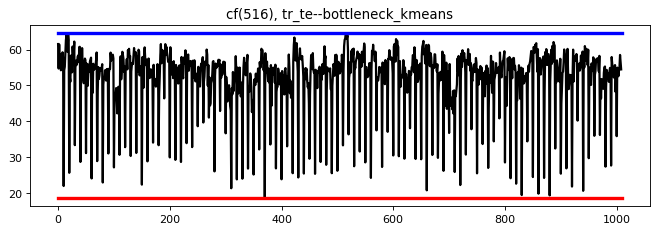

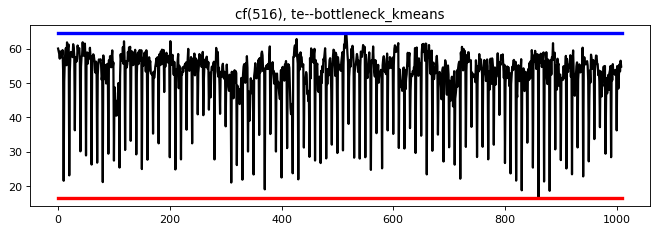

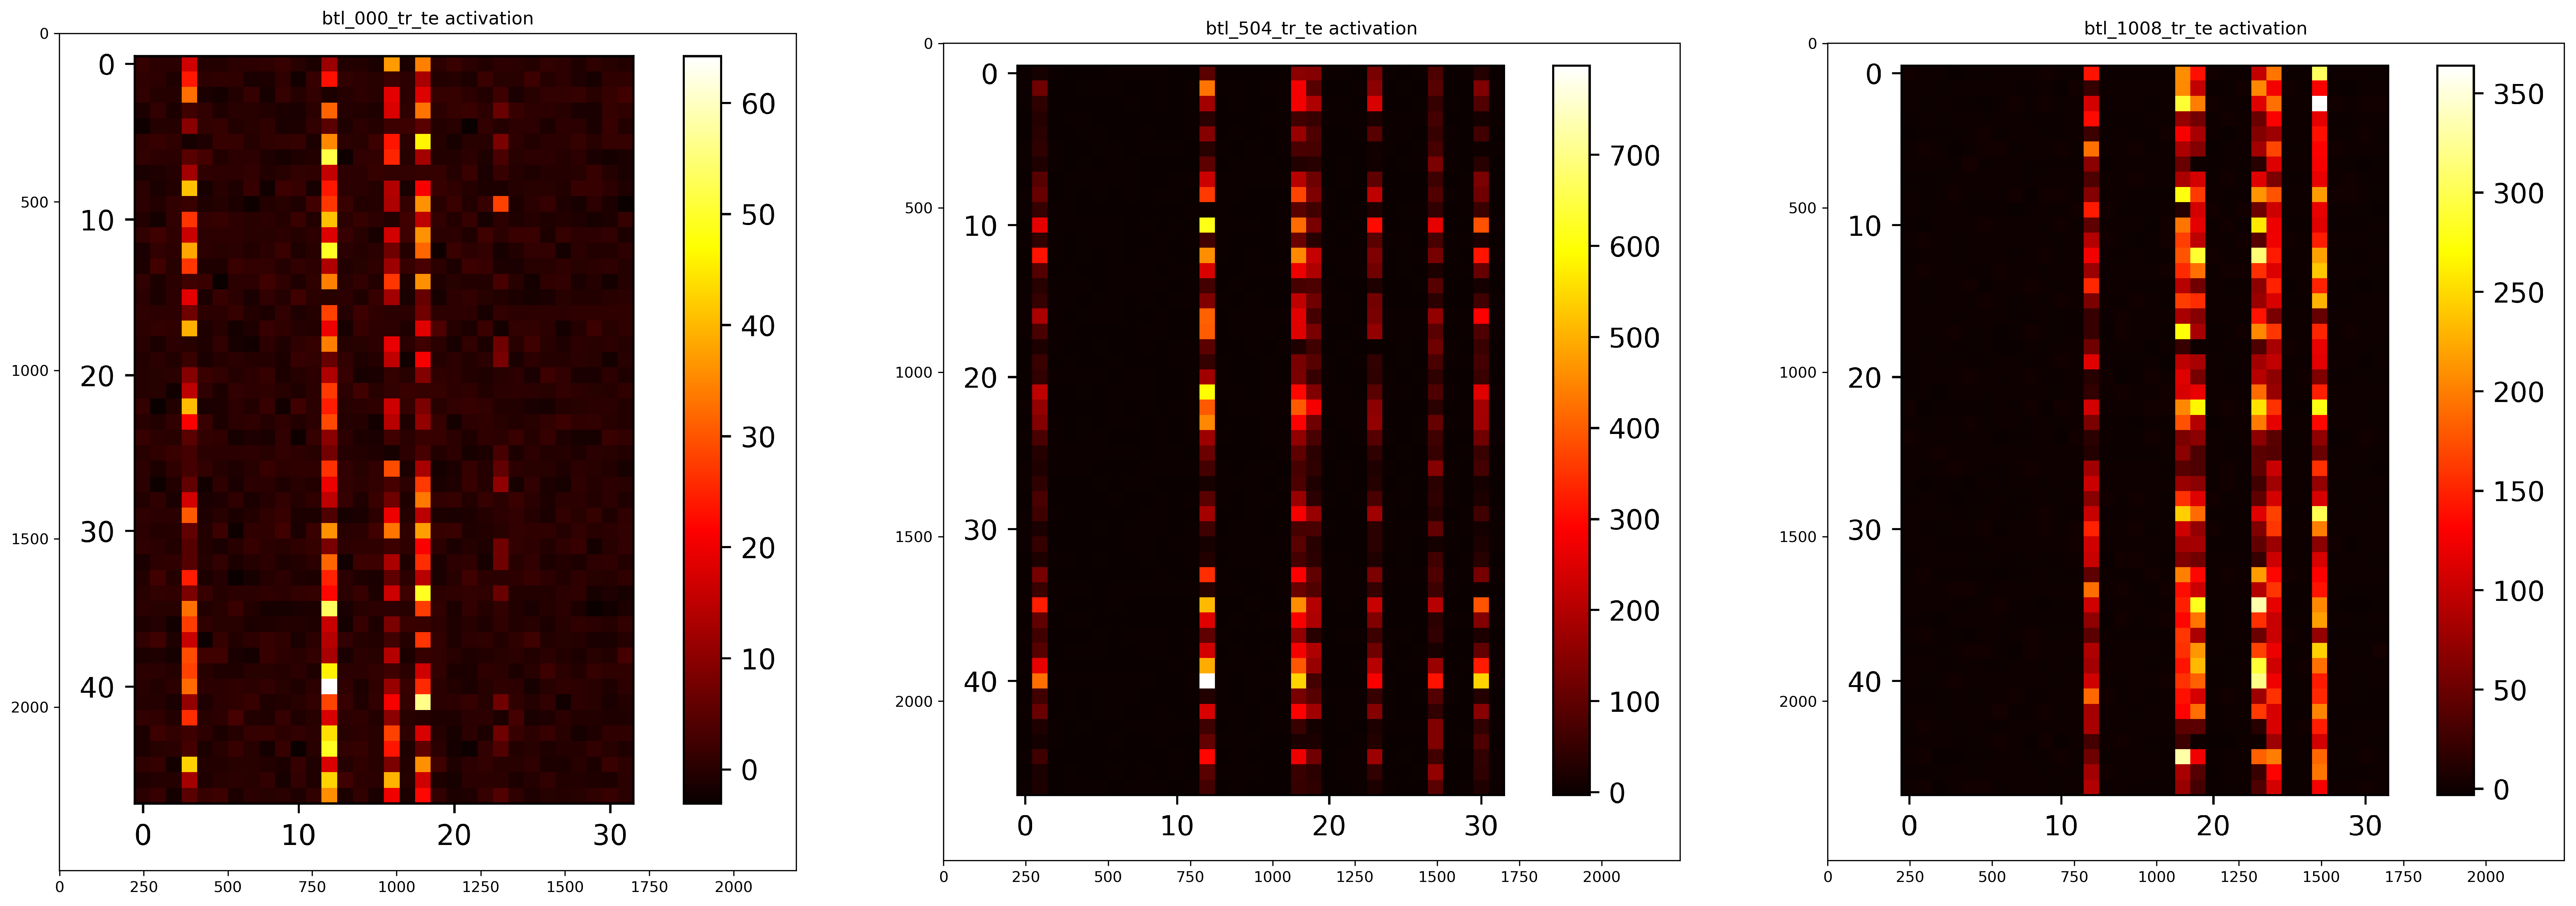

In [8]:
import vae_utils as vu
impL.reload(vu)
vu.plot_cf(cf_int=516, data_log_keys = ['tr_te', 'te'], max_act_ep=None, plot_cnt = 3,
            select_id_type='linspace', k_loss_disp_list={'bottleneck_kmeans'},
            experiments_folder='/home/doga/DataFolder/vaesae_experiments_cor',
            exp_base_name='exp_linear_vae_FMNIST_is28_cf',
            plt_min_max_lines=True)

In [ ]:
get_cluster_correspondance_ids(b_v, cluster_ids=[0,0,0,0,1,1,2,2,1,1], correspondance_type="knear3", verbose=1)